In [87]:
# import packages
import lyricsgenius
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
import nltk
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm.preprocessing import flatten
from nltk.util import pad_sequence
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk import sent_tokenize 
from nltk import PorterStemmer
from collections import Counter
from nltk.lm import MLE
import string
import re

## Songs Import

In [85]:
genius = lyricsgenius.Genius("ZExVs__STRbuPFCG3kJSeXFHHUKpY7O48f9vML2Ent3qLdsofip96c0keQtnAM9B")
genius.remove_section_headers = True
genius.excluded_terms = ["(Remix)", "(Live)", "(Radio Edit)", "(Türkçe Çeviri)"]

In [ ]:
#ran code in collab & saved to txt
artist = genius.search_artist('Eminem', sort='popularity', max_songs=150)
artist.save_lyrics(extension = 'txt')

In [50]:
#open file with 150 songs
file = open('Lyrics_Eminem.txt')
lyrics = file.read()

## Prepare & look at data

In [60]:
# tokenize by sentence
sentences = sent_tokenize(lyrics)

In [63]:
# tokenize by word in a sentence
tokenized_sentences = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(lyrics)]

In [62]:
sentences[5]

"Like something's about to happen, but I don't know what."

In [64]:
tokenized_sentences[5]

['like',
 'something',
 "'s",
 'about',
 'to',
 'happen',
 ',',
 'but',
 'i',
 'do',
 "n't",
 'know',
 'what',
 '.']

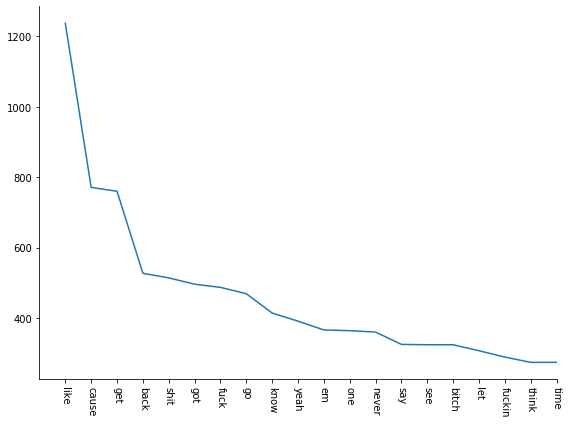

In [6]:
# let's see most common words
dist = FreqDist(lyrics)
fig, ax = plt.subplots(figsize=(8,6))

y = pd.Series(dict(dist.most_common()[:20]))
y = y.sort_values(ascending=False)

y.plot()

indexes = np.arange(0, len(y))
ax.set_xticks(indexes)
ax.set_xticklabels(y.index, rotation='-90')
ax.set_xlim(-1)

plt.tight_layout()

sns.despine()
plt.show()

## Models

In [140]:
# define function to clean generated text
def generate_sent(model, num_words, random_seed = 1):
    detokenize = TreebankWordDetokenizer().detokenize
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [169]:
# define function to split generated text in verses
terminators = ['.', ',', '!', '?', ')']
def find_sentences(paragraph):
   end = True
   sentences = []
   while end > -1:
       end = find_sentence_end(paragraph)
       if end > -1:
           sentences.append(paragraph[end:].strip())
           paragraph = paragraph[:end]
   sentences.append(paragraph)
   sentences.reverse()
   return sentences

### Bigram model

In [217]:
# create vocabulary
train, vocab = padded_everygram_pipeline(2, tokenized_sentences)

In [218]:
# padding
train_data, padded_sents = padded_everygram_pipeline(2, tokenized_sentences)

In [145]:
model = MLE(2)

In [146]:
model.fit(train_data, padded_sents)

In [168]:
print(model.generate(100, random_seed=24))

['pieces', 'of', 'course', 'you', ',', 'people', ',', 'stop', ',', 'self-absorption', 'skeletor', ',', 'i', 'suffer', 'this', 'battle', 'a', 'weapon', "i'ma", 'kill', 'him', 'when', 'he', 'played', 'that', "'s", 'god', ',', 'know', 'my', 'swag', 'juice', ',', 'why', '?', ')', 'it', 'pours', '—', 'you', 'think', 'i', 'meant', 'to', 'be', 'like', 'a', 'cigarette', 'now', 'let', 'yourself', "''", 'and', 'your', 'shit', 'get', 'down', 'my', 'dreams', 'last', 'rock', 'bottom', 'like', 'he', 'dawg', 'from', 'futons', 'to', 'my', 'head', 'up', 'a', 'grip', ',', 'i', "'m", 'ill', 'though', '(', 'you', 'only', 'time', 'it', 'dies', 'as', 'i', "'m", 'east', 'side', 'chick', 'with', 'the', 'people', "'s", 'driving', 'do', "n't", 'have', 'pictures', 'so']


In [167]:
generate_sent(model, 100, random_seed=24)

'pieces of course you, people, stop, self-absorption skeletor, i suffer this battle a weapon i\'ma kill him when he played that\'s god, know my swag juice, why?) it pours — you think i meant to be like a cigarette now let yourself"and your shit get down my dreams last rock bottom like he dawg from futons to my head up a grip, i\'m ill though (you only time it dies as i\'m east side chick with the people\'s driving don\'t have pictures so'

In [170]:
find_sentences(generate_sent(model, 100, random_seed=24))

['pieces of course you,',
 'people,',
 'stop,',
 'self-absorption skeletor,',
 "i suffer this battle a weapon i'ma kill him when he played that's god,",
 'know my swag juice,',
 'why?)',
 'it pours — you think i meant to be like a cigarette now let yourself"and your shit get down my dreams last rock bottom like he dawg from futons to my head up a grip,',
 "i'm ill though (you only time it dies as i'm east side chick with the people's driving don't have pictures so"]

In [226]:
import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Vocabulary
train, test = train_test_split(tokenized_sentences, test_size = 0.2, random_state = 1)

train_sentences = train
tokenized_text = tokenized_sentences

n = 2
train_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
words = [word for sent in tokenized_text for word in sent]
words.extend(["<s>", "</s>"])
padded_vocab = Vocabulary(words)
model = MLE(n)
model.fit(train_data, padded_vocab)

test_sentences = test
tokenized_text = tokenized_sentences

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
for test in test_data:
    print ("MLE Estimates:", [((ngram[-1], ngram[:-1]),model.score(ngram[-1], ngram[:-1])) for ngram in test])

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
for i, test in enumerate(test_data):
  print("PP({0}):{1}".format(test_sentences[1], model.perplexity(test)))

MLE Estimates: [(('``', ('<s>',)), 0.020425531914893616), (('look', ('``',)), 0.00804289544235925), ((',', ('look',)), 0.13125), (('i', (',',)), 0.13529812275070519), (('was', ('i',)), 0.030145955531305415), (('gon', ('was',)), 0.014109347442680775), (('na', ('gon',)), 0.7744107744107744), (('go', ('na',)), 0.04421052631578947), (('easy', ('go',)), 0.0021551724137931034), (('on', ('easy',)), 0.08333333333333333), (('you', ('on',)), 0.034453057708871665), (('not', ('you',)), 0.0012218963831867058), (('to', ('not',)), 0.06218905472636816), (('hurt', ('to',)), 0.0038363171355498722), (('your', ('hurt',)), 0.04), (('feelings', ('your',)), 0.002932551319648094), (('.', ('feelings',)), 0.09090909090909091), (("''", ('.',)), 0.48484848484848486), (('</s>', ("''",)), 0.34177215189873417)]
MLE Estimates: [(('``', ('<s>',)), 0.020425531914893616), (('but', ('``',)), 0.00804289544235925), (('i', ('but',)), 0.2920517560073937), (("'m", ('i',)), 0.26776701677806575), (('only', ("'m",)), 0.007633587

MLE Estimates: [(('and', ('<s>',)), 0.027659574468085105), (('though', ('and',)), 0.0006894174422612892), (('me', ('though',)), 0.0136986301369863), (('and', ('me',)), 0.041736227045075125), (('my', ('and',)), 0.012064805239572561), (('party', ('my',)), 0.000526592943654555), (('days', ('party',)), 0.038461538461538464), (('have', ('days',)), 0.04), (('all', ('have',)), 0.00949367088607595), (('pretty', ('all',)), 0.0015923566878980893), (('much', ('pretty',)), 0.17647058823529413), (('parted', ('much',)), 0.008064516129032258), (('ways', ('parted',)), 1.0), (('you', ('ways',)), 0.05555555555555555), (("'d", ('you',)), 0.009530791788856305), (('swear', ("'d",)), 0.0045871559633027525), (('to', ('swear',)), 0.24), (('god', ('to',)), 0.00319693094629156), (('i', ('god',)), 0.047619047619047616), (('forgot', ('i',)), 0.0013640703860319193), (('i', ('forgot',)), 0.05555555555555555), (("'m", ('i',)), 0.26776701677806575), (('the', ("'m",)), 0.03155216284987277), (('guy', ('the',)), 0.00185

MLE Estimates: [(('especially', ('<s>',)), 0.000851063829787234), (('when', ('especially',)), 0.4), (('dad', ('when',)), 0.0016835016835016834), ((',', ('dad',)), 0.2807017543859649), (('he', (',',)), 0.010213014298220018), (('fucked', ('he',)), 0.0022935779816513763), (('us', ('fucked',)), 0.023255813953488372), (('both', ('us',)), 0.023809523809523808), (('we', ('both',)), 0.03125), (("'re", ('we',)), 0.16455696202531644), (('in', ("'re",)), 0.03273322422258593), (('the', ('in',)), 0.27355072463768115), (('same', ('the',)), 0.02205711632226608), (('fuckin', ('same',)), 0.017699115044247787), (("'", ('fuckin',)), 0.9929078014184397), (('boat', ("'",)), 0.000357653791130186), (('you', ('boat',)), 1.0), (("'d", ('you',)), 0.009530791788856305), (('think', ("'d",)), 0.013761467889908258), (('that', ('think',)), 0.06666666666666667), (("'d", ('that',)), 0.001310615989515072), (('make', ("'d",)), 0.022935779816513763), (('us', ('make',)), 0.00392156862745098), (('close', ('us',)), 0.007936

MLE Estimates: [(('i', ('<s>',)), 0.11872340425531915), (('got', ('i',)), 0.027417814759241578), (('some', ('got',)), 0.0165016501650165), (('skeletons', ('some',)), 0.0048543689320388345), (('in', ('skeletons',)), 0.875), (('my', ('in',)), 0.09541062801932366), (('closet', ('my',)), 0.009478672985781991), (('and', ('closet',)), 0.047619047619047616), (('i', ('and',)), 0.13409169251982075), (('do', ('i',)), 0.05033419724457782), (("n't", ('do',)), 0.6691729323308271), (('know', ("n't",)), 0.04911180773249739), (('if', ('know',)), 0.012165450121654502), (('no', ('if',)), 0.00211864406779661), (('one', ('no',)), 0.09359605911330049), (('knows', ('one',)), 0.002857142857142857), (('it', ('knows',)), 0.0196078431372549), (('so', ('it',)), 0.002470152326060107), (('before', ('so',)), 0.004514672686230248), (('they', ('before',)), 0.06329113924050633), (('throw', ('they',)), 0.005235602094240838), (('me', ('throw',)), 0.15), (('inside', ('me',)), 0.0011129660545353367), (('my', ('inside',)),

MLE Estimates: [(('‘', ('<s>',)), 0.01148936170212766), (('cause', ('‘',)), 0.954954954954955), (('i', ('cause',)), 0.3008130081300813), (("'m", ('i',)), 0.26776701677806575), (('stronger', ("'m",)), 0.0015267175572519084), (('than', ('stronger',)), 0.6666666666666666), (('i', ('than',)), 0.11023622047244094), (('was', ('i',)), 0.030145955531305415), (('a', ('was',)), 0.05114638447971781), (('beautiful', ('a',)), 0.003870967741935484), (('face', ('beautiful',)), 0.03571428571428571), (('is', ('face',)), 0.04395604395604396), (('all', ('is',)), 0.01122334455667789), (('that', ('all',)), 0.025477707006369428), (('you', ('that',)), 0.05111402359108781), (('have', ('you',)), 0.004398826979472141), (('‘', ('have',)), 0.006329113924050633), (('cause', ('‘',)), 0.954954954954955), (('on', ('cause',)), 0.0040650406504065045), (('the', ('on',)), 0.20155038759689922), (('inside', ('the',)), 0.0006965405154399814), (('you', ('inside',)), 0.058823529411764705), (("'re", ('you',)), 0.11094819159335

MLE Estimates: [(('we', ('<s>',)), 0.01148936170212766), (("'ll", ('we',)), 0.03164556962025317), (('be', ("'ll",)), 0.15610859728506787), (('right', ('be',)), 0.005221932114882507), (('back', ('right',)), 0.03428571428571429), (('—', ('back',)), 0.0038314176245210726), (('well', ('—',)), 0.058823529411764705), ((',', ('well',)), 0.7586206896551724), (('i', (',',)), 0.13529812275070519), (('will', ('i',)), 0.005047060428318101), ((',', ('will',)), 0.04477611940298507), (('you', (',',)), 0.054080342379145996), (("'ll", ('you',)), 0.017595307917888565), (('be', ("'ll",)), 0.15610859728506787), (('in', ('be',)), 0.020887728459530026), (('the', ('in',)), 0.27355072463768115), (('trunk', ('the',)), 0.0013930810308799629), (('so', ('trunk',)), 0.125), (('long', ('so',)), 0.012415349887133182), ((',', ('long',)), 0.11764705882352941), (('bitch', (',',)), 0.011185682326621925), ((',', ('bitch',)), 0.4462025316455696), (('you', (',',)), 0.054080342379145996), (('did', ('you',)), 0.0053763440860

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [(('if', ('<s>',)), 0.006808510638297872), (('there', ('if',)), 0.023305084745762712), (('is', ('there',)), 0.05592105263157895), ((',', ('is',)), 0.07856341189674523), (('let', (',',)), 0.00768407742437506), (('me', ('let',)), 0.20394736842105263), (('hear', ('me',)), 0.0022259321090706734), (('just', ('hear',)), 0.04395604395604396), (('so', ('just',)), 0.016008537886873), (('i', ('so',)), 0.08803611738148984), (('know', ('i',)), 0.017187286864002182), (('that', ('know',)), 0.1192214111922141), (('i', ('that',)), 0.15072083879423329), (("'m", ('i',)), 0.26776701677806575), (('not', ("'m",)), 0.04580152671755725), (('the', ('not',)), 0.03233830845771144), (('only', ('the',)), 0.009983747387973066), (('one', ('only',)), 0.08333333333333333), (('i', ('one',)), 0.025714285714285714), (('went', ('i',)), 0.0038193970808893737), (('away', ('went',)), 0.0273972602739726), ((',', ('away',)), 0.09210526315789473), (('i', (',',)), 0.13529812275070519), (('guess', ('i',)), 0.008048015277588324)

MLE Estimates: [(('baby', ('<s>',)), 0.000425531914893617), ((',', ('baby',)), 0.42138364779874216), (('you', (',',)), 0.054080342379145996), (('should', ('you',)), 0.005376344086021506), (("n't", ('should',)), 0.16326530612244897), (('have', ("n't",)), 0.0219435736677116), (('any', ('have',)), 0.022151898734177215), (('trouble', ('any',)), 0.01639344262295082), (('rubbing', ('trouble',)), 0.09090909090909091), (('groins', ('rubbing',)), 0.5), (('with', ('groins',)), 1.0), (('each', ('with',)), 0.003188097768331562), (('other', ('each',)), 0.6065573770491803), ((',', ('other',)), 0.05434782608695652), (('especially', (',',)), 9.726680284019065e-05), (('when', ('especially',)), 0.4), (('you', ('when',)), 0.19023569023569023), (("'re", ('you',)), 0.11094819159335288), (('joined', ("'re",)), 0.0016366612111292963), (('at', ('joined',)), 1.0), (('the', ('at',)), 0.1875), (('hip', ('the',)), 0.0013930810308799629), (('i', ('hip',)), 0.07142857142857142), (("'m", ('i',)), 0.26776701677806575

MLE Estimates: [(('now', ('<s>',)), 0.01148936170212766), (('with', ('now',)), 0.004705882352941176), (('this', ('with',)), 0.03294367693942614), (('bein', ('this',)), 0.0009174311926605505), (("'", ('bein',)), 0.9512195121951219), (('the', ("'",)), 0.027181688125894134), (('new', ('the',)), 0.0023218017181332712), (('trend', ('new',)), 0.011627906976744186), ((',', ('trend',)), 1.0), (('we', (',',)), 0.007781344227215252), (('do', ('we',)), 0.03955696202531646), (("n't", ('do',)), 0.6691729323308271), (('fit', ("n't",)), 0.0020898641588296763), (('in', ('fit',)), 0.25), (('crackas', ('in',)), 0.0006038647342995169), (('is', ('crackas',)), 1.0), (('out', ('is',)), 0.004489337822671156), (('with', ('out',)), 0.014519056261343012), (('cactus', ('with',)), 0.0010626992561105207), (('albums', ('cactus',)), 0.5), ((',', ('albums',)), 0.3333333333333333), (('blackness', (',',)), 9.726680284019065e-05), (('is', ('blackness',)), 1.0), (('in', ('is',)), 0.01122334455667789), (('african', ('in',

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):34.9852023689398
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):34.7118497628851
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):33.64768737570329
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):31.1311442383273

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):34.211724853810615
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):12.349175234540665
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):53.014138418104174
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):53.01413841

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):40.90210961370261
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):27.425144226958558
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):30.577285986252217
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):23.190948463

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):23.624783995868544
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):20.789248070253663
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):40.75395090750263
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):33.865786817

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):31.64689377421817
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):33.072289038269446
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):31.255330838870748
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):34.612037859

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):41.50642374608898
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):6.894902056983938
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):17.466562571520416
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):15.4378302447

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):37.8750459112013
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):38.67021273924733
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):13.476479564869592
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):12.66673607580

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):47.241012045710136
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):37.86617449926688
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):51.49315546764828
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):42.4987102591

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):42.5390099172224
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):27.890505392641906
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):35.62004821572425
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):15.77581506622

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):23.180948066529425
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):22.21348759397155
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):29.059896445136864
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):29.085561866

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):30.12722907725227
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):50.484345823530546
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):44.312924109565756
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):26.512903230

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):28.70986713427906
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):47.82460106934454
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):44.11646801556291
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):34.28190187734

PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):22.07127623185493
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):32.273737090988945
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):54.944806026965296
PP(['i', "'ll", 'put', 'out', 'this', 'last', 'album', ',', 'then', 'i', "'m", 'done', 'with', 'it', 'one', 'hundred', 'percent', 'finished', ',', 'fed', 'up', 'with', 'it', 'i', "'m", 'hanging', 'it', 'up', ',', 'fuck', 'it', '!']):39.059812007

### Trigram model

In [172]:
# create vocabulary
train, vocab = padded_everygram_pipeline(3, tokenized_sentences)

In [178]:
# padding
train_data, padded_sents_3 = padded_everygram_pipeline(3, tokenized_sentences)

In [175]:
model_1 = MLE(3)

In [179]:
model_1.fit(train_data, padded_sents_3)

In [181]:
print(model_1.generate(100, random_seed=24))

['over', 'these', 'hoes', 'wo', "n't", 'lock', 'it', ',', 'ca', "n't", 'see', 'what', 'it', 'sounds', 'like', 'a', 'nightstick', '(', 'yeah', ')', 'do', 'you', 'date', 'my', 'friends', 'ca', "n't", 'cum', 'in', 'her', 'vagina', 'said', 'my', 'last', 'album', ',', 'then', 'walk', 'up', 'to', 'the', 'dear', "'ol", 'dad', 'that', 'i', "'m", 'at', 'your', 'throat', 'when', 'you', 'laugh', 'i', 'can', 'just', 'open', 'enough', 'eyes', 'later', 'on', 'and', 'prolong', 'these', 'moments', '‘', 'cause', 'i', "don't", 'and', 'why', ',', 'look', ',', 'if', 'i', 'forget', 'to', 'bring', 'your', 'lipstick', 'wit', "'", 'ya', 'digs', 'in', 'the', 'dirt', 'and', 'fuck', 'your', 'republican', 'views', 'pull', 'ourselves', 'up', 'by', 'our', 'bootstraps', ',']


In [183]:
generate_sent(model_1, 100, random_seed=24)

"over these hoes won't lock it, can't see what it sounds like a nightstick (yeah) do you date my friends can't cum in her vagina said my last album, then walk up to the dear 'ol dad that i'm at your throat when you laugh i can just open enough eyes later on and prolong these moments ‘ cause i don't and why, look, if i forget to bring your lipstick wit' ya digs in the dirt and fuck your republican views pull ourselves up by our bootstraps ,"

In [185]:
find_sentences(generate_sent(model_1, 100, random_seed=24))

["over these hoes won't lock it,",
 "can't see what it sounds like a nightstick (yeah)",
 "do you date my friends can't cum in her vagina said my last album,",
 "then walk up to the dear 'ol dad that i'm at your throat when you laugh i can just open enough eyes later on and prolong these moments ‘ cause i don't and why,",
 'look,',
 "if i forget to bring your lipstick wit' ya digs in the dirt and fuck your republican views pull ourselves up by our bootstraps ,"]

### Four-gram

In [205]:
# create vocabulary
train, vocab = padded_everygram_pipeline(4, tokenized_sentences)

In [206]:
# padding
train_data, padded_sents_4 = padded_everygram_pipeline(4, tokenized_sentences)

In [207]:
model_2 = MLE(4)

In [208]:
model_2.fit(train_data, padded_sents_4)

In [209]:
print(model_2.generate(100, random_seed=23))

['way', 'you', 'shake', 'it', ',', 'i', 'ai', "n't", 'fo', "'", 'that', 'shit', 'behind', 'my', 'back', ',', 'dirty', "mackin'", 'tellin', "'", 'your', 'boys', 'that', 'i', "'m", 'from', 'will', 'pummel', 'you', ',', 'that', "'s", 'none', 'of', 'your', 'dang', 'skulls', ';', 'i', "'m", 'infinite', 'bust', 'it', ',', 'i', "'m", 'mixin', "'", 'our', 'studio', 'session', 'down', 'and', 'sendin', "'", 'it', 'to', 'masterin', "'", 'to', 'make', 'it', 'right', ',', 'so', 'here', "'s", 'how', 'i', 'knew', 'my', 'mission', 'little', 'boom', 'box', 'boomin', "'", ',', "spittin'", 'practicin', "'", 'numerous', 'writtens', 'when', 'i', "'d", 'sit', 'in', 'my', 'room', ',', 'yeah', ',', 'i', 'never', 'knew', 'i', ',', 'knew', 'i']


In [210]:
generate_sent(model_2, 100, random_seed=23)

"way you shake it, i ain't fo' that shit behind my back, dirty mackin' tellin' your boys that i'm from will pummel you, that's none of your dang skulls; i'm infinite bust it, i'm mixin' our studio session down and sendin' it to masterin' to make it right, so here's how i knew my mission little boom box boomin', spittin' practicin' numerous writtens when i'd sit in my room, yeah, i never knew i, knew i"

In [211]:
find_sentences(generate_sent(model_2, 100, random_seed=23))

['way you shake it,',
 "i ain't fo' that shit behind my back,",
 "dirty mackin' tellin' your boys that i'm from will pummel you,",
 "that's none of your dang skulls; i'm infinite bust it,",
 "i'm mixin' our studio session down and sendin' it to masterin' to make it right,",
 "so here's how i knew my mission little boom box boomin',",
 "spittin' practicin' numerous writtens when i'd sit in my room,",
 'yeah,',
 'i never knew i,',
 'knew i']

In [212]:
from collections import *

def train_char_lm(fname, order=4):
    data = open(fname).read()
    lm = defaultdict(Counter)
    pad = "~" * order
    data = pad + data
    for i in range(len(data)-order):
        history, char = data[i:i+order], data[i+order]
        lm[history][char]+=1
    def normalize(counter):
        s = float(sum(counter.values()))
        return [(c,cnt/s) for c,cnt in counter.items()]
    outlm = {hist:normalize(chars) for hist, chars in lm.items()}
    return outlm

In [213]:
from random import random

def generate_letter(lm, history, order):
        history = history[-order:]
        dist = lm[history]
        x = random()
        for c,v in dist:
            x = x - v
            if x <= 0: return c

In [214]:
def generate_text(lm, order, nletters=1000):
    history = "~" * order
    out = []
    for i in range(nletters):
        c = generate_letter(lm, history, order)
        history = history[-order:] + c
        out.append(c)
    return "".join(out)

In [215]:
lm = train_char_lm("Lyrics_Eminem.txt", order=2)
print (generate_text(lm, 2))

"Loo dre liumpee shing oh, I don'
This if youts
But I'm figgain't blass ocka
So, thes withe bould sed screard thin't the out fuld st me cy, want
Thropeen do goombeat a thisse a now wana 2Pack (Hught scrynand astor tait," (yet I'm a se I hat and D, an
Bes bas thazy!
Espick it, henterid theare
Halrijusce to me but water now lin sheall getwit, ye yon'
Marave, I le to hervorgothe I st lown
Butot, ong
She sh, al thiss, and ithey "Dad
To wour gropplike thean bet me, I'm H-I-a-
Raped one
Warter, thappla Mare."
Shol"
"Monems dis the my cooplat I this so
Tharou con't the hostered pind guy Won coven asse for my ing
Don youd I'm umbe puntees bect my oneve pos hou, tryna taking (Yeally fuch thithe an I'm cuze be a mexplackin evild of Stre I jus mys clock
On gother sam ouread be
I trou come le Snot on
Prout me mis, sou, appoppormainge, I loome won't ack thithit this con se sh
And hat a al?
No MC's a wess have ly, like ton' uplum

‘Card (non’t dookey cry snons sic (Fornefictiou
Boyed LP2
The sainget